In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings 
warnings.filterwarnings('ignore')

<h2> Notebook overview </h2>

- In this notebook, I will work with the data spanning the years 2011–2012
- I will create a linear regression model that predicts the number of users 

<h4> Part 1 </h4>

- Load and pre-process data

<h4> Part 2 </h4>

- Feature reduction through iterative computation of VIF scores and P-values

<h4> Part 3 </h4>

- Linear regression with chosen features

<h4> Part 4 </h4>

- Alternate selection of features using common sense and domain knowledge
- Check VIF scores and P-values of chosen features
- Linear regression with chosen features
- Plot ground-truth values vs predicted values
- Plot residuals – check for random distribution

<h4> Part 5 </h4>

- Exploration of regularisation

<h3> 1) Load data and pre-process </h3>

<h4> 1.1) Load data </h4>

In [7]:
# read csv
df_daily = pd.read_csv('cleaned_data/df_daily.csv')

# create X and y arrays
X = df_daily.copy(deep = True)
X = X.drop(['casual', 'registered', 'total', 'year_month','app_temp_cat', 'date', 'calendar_week'], axis = 1)
y = df_daily['total']

In [8]:
X.head(3)


,season,year,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,wind_speed
0,winter,2011,1,no,sat,no,misty,8.2,8.0,80.6,10.7
1,winter,2011,1,no,sun,no,misty,9.1,7.3,69.6,16.7
2,winter,2011,1,no,mon,yes,clear,1.2,-3.5,43.7,16.6


In [9]:
y.head(3)

0     985
1     801
2    1349
Name: total, dtype: int64

<h4> 1.2) Overview of features </h4>

- We have both numerical and categorical variables, which will need to be processed differently.
- We need to convert the categorical variables into one-hot encodings. 

<h4> Numerical variables </h4>

- temp
- app_temp
- humidity
- wind_speed

<h4> Categorical variables </h4>

- season
- year
- month
- holiday
- day_of_week
- work_day
- weather_sit

<h4> 1.3) One-hot encoding for categorical variables </h4>

In [10]:
# change datatype for "month" and "year" to string (in order to one-hot encode)
X['month'] = X['month'].apply(str)
X['year'] = X['year'].apply(str)

# one-hot encode the categorical variables
X_enc = pd.get_dummies(X, drop_first = True)

In [12]:
X_enc.head()

,temp,app_temp,humidity,wind_speed,season_spring,season_summer,season_winter,year_2012,month_10,month_11,...,holiday_yes,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,work_day_yes,weather_sit_clear,weather_sit_misty
0,8.2,8.0,80.6,10.7,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,9.1,7.3,69.6,16.7,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1.2,-3.5,43.7,16.6,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
3,1.4,-2.0,59.0,10.7,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,1,0
4,2.7,-0.9,43.7,12.5,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,0


In [13]:
X_enc.columns

Index(['temp', 'app_temp', 'humidity', 'wind_speed', 'season_spring',
       'season_summer', 'season_winter', 'year_2012', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'holiday_yes', 'day_of_week_mon',
       'day_of_week_sat', 'day_of_week_sun', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'work_day_yes',
       'weather_sit_clear', 'weather_sit_misty'],
      dtype='object')

<h3> 2) Feature selection </h3> 

<h4> 2.1) Remove variables with high multicollinearity </h4>

<h5> 2.1.1) Function for computing VIF </h5>

In [15]:
def compute_vif(considered_features):
    """
    Create dataframe with "variable" and "vif" column

    Arguments:
    considered_features -- list of features

    Returns:
    vif -- dataframe
    """
    
    # make deep copy of X_enc
    X_temp = X_enc.copy(deep = True)

    # scale continuous variables
    scaler = StandardScaler()
    scaler.fit(X_temp[['temp', 'app_temp', 'humidity']])
    X_temp[['temp', 'app_temp', 'humidity']] = scaler.transform(X_temp[['temp', 'app_temp', 'humidity']])

    # Select considered features only
    X_temp = X_enc[considered_features]

    # Add intercept = 1 for ViF calculation:
    X_temp['intercept'] = 1

    # Create dataframe to store values
    vif = pd.DataFrame()
    # Create "variable" column
    vif['variable'] = X_temp.columns
    # Create "vif" column and fill with respective VIF scores
    vif['vif'] = [variance_inflation_factor(X_temp.values, i) for i in list(range(X_temp.shape[1]))]
    # select columns without "intercept" column
    vif = vif[vif['variable']!= 'intercept']
    return vif


<h5> 2.1.2) Iteratively remove variables with VIF score over 5 </h5>

- When we compute the VIF scores of features, we are regressing each feature against all the other features.
- As such, we obtain a metric that measures how correlated each feature is with all others.
- Higher VIF score indicates higher correlation. 
- We remove features with a VIF score over 5

In [16]:
# Compute VIF for full list of features
considered_features = X_enc.columns.tolist()
compute_vif(considered_features)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,season_winter,inf
7,year_2012,1.046125
8,month_10,inf
9,month_11,inf


In [17]:
# Several features with very high VIF score.
# We know that "work_day" depends on "day_of_week" and "holiday", so remove "work_day":
considered_features.remove('work_day_yes')

# Save reduced features list
considered_features2 = considered_features
compute_vif(considered_features2)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,season_winter,inf
7,year_2012,1.046125
8,month_10,inf
9,month_11,inf


In [18]:
# Good. Now VIF scores for all "day_of_week" values are reasonable.
# Now I'm not sure whether to remove the seasons or the months. 
# Seasonal boundaries fall in the middle of different months, so removing seasons leads to loss of info.
# But the weather conditions do fluctuate from month to month within same season.
# For now, remove the seasons.

considered_features2.remove('season_winter')
considered_features3 = considered_features2
compute_vif(considered_features3)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,year_2012,1.046125
7,month_10,2.779288
8,month_11,2.075357
9,month_12,1.971167


In [19]:
# Remove summer

considered_features3.remove('season_summer')
considered_features4 = considered_features3
compute_vif(considered_features4)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,year_2012,1.046125
6,month_10,2.779288
7,month_11,2.075357
8,month_12,1.971167
9,month_2,1.834470


In [20]:
# Remove spring
considered_features4.remove('season_spring')
considered_features5 = considered_features4
compute_vif(considered_features5)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,year_2012,1.046125
5,month_10,2.779288
6,month_11,2.075357
7,month_12,1.971167
8,month_2,1.834470
9,month_3,2.219708


In [21]:
# Remove app_temp
considered_features5.remove('temp')
considered_features6 = considered_features5
compute_vif(considered_features6)

,variable,vif
0,app_temp,5.951702
1,humidity,2.130698
2,wind_speed,1.206828
3,year_2012,1.041506
4,month_10,2.725352
5,month_11,2.070150
6,month_12,1.970113
7,month_2,1.833683
8,month_3,2.198147
9,month_4,2.618455


In [22]:
# Our three weather_sit classes were: "clear", "misty", and "bit wet"
# If we drop "misty", then we'd be lumping "misty" together with "bit wet", which doesn't seem right. 
# Keep both "weather_sit" values for now, even though the VIFs are high-ish. 
# Also keep "app_temp" in spite of the high VIF, since we know from the EDA it will be an important predictor.

In [23]:
# Save our chosen features
selected_features = considered_features6

<h4> 2.2) Select variables that meaningfully predict outcome </h4>

- Compute p-values for features, and iteratively remove the ones with a p-value above 0.05
- The higher the p-value, the likelier it is that the null-hypothesis is correct.

In [25]:
# Copy X dataframe and scale numerical variables

X_opt = X_enc.copy(deep = True)
X_opt = X_opt[selected_features]

scaler = StandardScaler()
scaler.fit(X_opt[['wind_speed', 'app_temp', 'humidity']])
X_opt[['wind_speed', 'app_temp', 'humidity']] = scaler.transform(X_opt[['wind_speed', 'app_temp', 'humidity']])

In [27]:
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1063.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:48:49   Log-Likelihood:                         -5928.4
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     707   BIC:                                  1.202e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            690.0325     64.252     10.740      0.000     563.886     816.179
humidity           -173.4975     41.819     -4.149      0.000    -255.601     -91.394
wind_speed         -218.9681     32.875     -6.661      0.000    -283.513    -154.423
year_2012          2050.3401     61.075     33.571      0.000    1930.431    2170.250
month_10           2330.5034    153.074     15.225      0.000    2029.970    2631.037
month_11           1627.6370    142.761     11.401      0.000    1347.351    1907.923
month_12           1058.8199    140.496      7.536      0.000     782.980    1334.660
month_2             270.5037    143.130      1.890      0.059     -10.507     551.514
month_3            1053.4907    143.564      7.338      0.000     771.629    1335.353
month_4            1579.3845    154.639     10.213      0.000    1275.777    1882.992
month_5            1907.5014    177.554     10.743      0.000    1558.905    2256.097
month_6            1774.9903    195.154      9.095      0.000    1391.839    2158.141
month_7            1299.0223    210.762      6.163      0.000     885.229    1712.816
month_8            1689.7559    197.659      8.549      0.000    1301.688    2077.824
month_9            2364.6203    177.973     13.286      0.000    2015.202    2714.039
holiday_yes        -684.1944    190.612     -3.589      0.000   -1058.428    -309.961
day_of_week_mon    -148.6622    113.260     -1.313      0.190    -371.028      73.703
day_of_week_sat      61.4029    110.502      0.556      0.579    -155.549     278.355
day_of_week_sun    -386.9456    111.819     -3.460      0.001    -606.483    -167.408
day_of_week_thu      33.3150    109.748      0.304      0.762    -182.156     248.786
day_of_week_tue     -43.2940    110.129     -0.393      0.694    -259.514     172.926
day_of_week_wed      34.0729    109.822      0.310      0.756    -181.543     249.689
weather_sit_clear  2373.7769    133.382     17.797      0.000    2111.904    2635.650
weather_sit_misty  1875.1864    131.149     14.298      0.000    1617.699    2132.674
==============================================================================
Omnibus:                      115.836   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.256
Skew:                          -0.815   Prob(JB):                     8.54e-67
Kurtosis:                       5.708   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly spec

In [29]:
# Highest p-value comes from day_of_week_thu, so drop that.
selected_features.remove('day_of_week_thu')
selected_features2 = selected_features
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features2]).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1110.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:49:44   Log-Likelihood:                         -5928.4
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     708   BIC:                                  1.201e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            688.2669     63.947     10.763      0.000     562.719     813.815
humidity           -172.5128     41.666     -4.140      0.000    -254.317     -90.709
wind_speed         -218.4191     32.805     -6.658      0.000    -282.825    -154.013
year_2012          2051.0422     60.992     33.628      0.000    1931.296    2170.789
month_10           2336.5803    151.662     15.407      0.000    2038.819    2634.341
month_11           1632.4268    141.795     11.513      0.000    1354.038    1910.816
month_12           1063.2475    139.648      7.614      0.000     789.075    1337.420
month_2             274.5147    142.427      1.927      0.054      -5.116     554.145
month_3            1058.7575    142.420      7.434      0.000     779.142    1338.373
month_4            1584.7680    153.521     10.323      0.000    1283.358    1886.178
month_5            1913.9928    176.148     10.866      0.000    1568.157    2259.829
month_6            1782.5052    193.453      9.214      0.000    1402.694    2162.316
month_7            1306.9937    208.985      6.254      0.000     896.689    1717.299
month_8            1697.1842    196.012      8.659      0.000    1312.350    2082.019
month_9            2371.4971    176.412     13.443      0.000    2025.144    2717.850
holiday_yes        -683.9238    190.488     -3.590      0.000   -1057.913    -309.935
day_of_week_mon    -164.4308    100.580     -1.635      0.103    -361.902      33.041
day_of_week_sat      45.7408     97.655      0.468      0.640    -145.988     237.469
day_of_week_sun    -402.9223     98.595     -4.087      0.000    -596.497    -209.348
day_of_week_tue     -58.7959     97.511     -0.603      0.547    -250.242     132.650
day_of_week_wed      18.7378     97.451      0.192      0.848    -172.589     210.065
weather_sit_clear  2384.4363    128.595     18.542      0.000    2131.964    2636.909
weather_sit_misty  1884.1122    127.728     14.751      0.000    1633.341    2134.883
==============================================================================
Omnibus:                      116.111   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.115
Skew:                          -0.817   Prob(JB):                     5.56e-67
Kurtosis:                       5.711   Cond. No.                         18.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Highest p-value from day_of_week_wed
selected_features2.remove('day_of_week_wed')
selected_features3 = selected_features2
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features3]).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1162.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:49:52   Log-Likelihood:                         -5928.5
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     709   BIC:                                  1.200e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            686.9982     63.562     10.808      0.000     562.205     811.791
humidity           -171.3719     41.213     -4.158      0.000    -252.287     -90.457
wind_speed         -218.2052     32.763     -6.660      0.000    -282.530    -153.880
year_2012          2051.5777     60.887     33.695      0.000    1932.038    2171.118
month_10           2339.5275    150.783     15.516      0.000    2043.493    2635.562
month_11           1634.5738    141.259     11.571      0.000    1357.238    1911.909
month_12           1064.8114    139.316      7.643      0.000     791.291    1338.332
month_2             276.7159    141.870      1.950      0.052      -1.820     555.251
month_3            1061.2135    141.750      7.487      0.000     782.914    1339.513
month_4            1587.7365    152.639     10.402      0.000    1288.059    1887.414
month_5            1917.3044    175.185     10.944      0.000    1573.360    2261.248
month_6            1786.9254    191.952      9.309      0.000    1410.062    2163.788
month_7            1311.6613    207.430      6.323      0.000     904.412    1718.911
month_8            1701.5521    194.559      8.746      0.000    1319.571    2083.533
month_9            2374.6249    175.541     13.527      0.000    2029.983    2719.267
holiday_yes        -684.3402    190.346     -3.595      0.000   -1058.050    -310.630
day_of_week_mon    -170.4735     95.480     -1.785      0.075    -357.930      16.983
day_of_week_sat      39.6902     92.383      0.430      0.668    -141.688     221.068
day_of_week_sun    -409.1476     93.065     -4.396      0.000    -591.863    -226.432
day_of_week_tue     -64.8048     92.305     -0.702      0.483    -246.029     116.419
weather_sit_clear  2387.9564    127.198     18.773      0.000    2138.226    2637.687
weather_sit_misty  1886.1609    127.196     14.829      0.000    1636.434    2135.887
==============================================================================
Omnibus:                      116.517   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.745
Skew:                          -0.819   Prob(JB):                     2.46e-67
Kurtosis:                       5.718   Cond. No.                         17.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Highest p-value from day_of_week_sat
selected_features3.remove('day_of_week_sat')
selected_features4 = selected_features3
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features4]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1219.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:50:04   Log-Likelihood:                         -5928.5
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     710   BIC:                                  1.200e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            684.0007     63.142     10.833      0.000     560.034     807.968
humidity           -170.5227     41.142     -4.145      0.000    -251.298     -89.747
wind_speed         -217.5770     32.712     -6.651      0.000    -281.801    -153.353
year_2012          2052.0524     60.842     33.728      0.000    1932.601    2171.504
month_10           2344.7762    150.201     15.611      0.000    2049.885    2639.667
month_11           1637.1159    141.054     11.606      0.000    1360.184    1914.048
month_12           1067.7271    139.070      7.678      0.000     794.689    1340.766
month_2             278.2814    141.742      1.963      0.050      -0.002     556.564
month_3            1064.2008    141.498      7.521      0.000     786.397    1342.005
month_4            1592.5411    152.141     10.468      0.000    1293.841    1891.241
month_5            1923.1582    174.554     11.018      0.000    1580.454    2265.863
month_6            1794.7649    190.973      9.398      0.000    1419.825    2169.705
month_7            1321.1231    206.139      6.409      0.000     916.409    1725.837
month_8            1708.8254    193.710      8.822      0.000    1328.513    2089.138
month_9            2381.4888    174.712     13.631      0.000    2038.475    2724.503
holiday_yes        -686.8726    190.146     -3.612      0.000   -1060.188    -313.558
day_of_week_mon    -180.0682     92.778     -1.941      0.053    -362.220       2.084
day_of_week_sun    -419.3867     89.910     -4.665      0.000    -595.907    -242.866
day_of_week_tue     -74.5128     89.445     -0.833      0.405    -250.121     101.096
weather_sit_clear  2393.4896    126.472     18.925      0.000    2145.186    2641.794
weather_sit_misty  1890.2056    126.775     14.910      0.000    1641.308    2139.103
==============================================================================
Omnibus:                      114.942   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.786
Skew:                          -0.808   Prob(JB):                     1.78e-66
Kurtosis:                       5.707   Cond. No.                         17.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Highest p-value from day_of_week_tue
selected_features4.remove('day_of_week_tue')
selected_features5 = selected_features4
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features5]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1281.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:50:15   Log-Likelihood:                         -5928.9
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     711   BIC:                                  1.199e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            684.6853     63.123     10.847      0.000     560.756     808.615
humidity           -173.0198     41.024     -4.218      0.000    -253.563     -92.477
wind_speed         -218.5216     32.685     -6.686      0.000    -282.693    -154.350
year_2012          2051.1740     60.820     33.726      0.000    1931.767    2170.581
month_10           2341.7078    150.123     15.599      0.000    2046.970    2636.446
month_11           1634.2205    140.980     11.592      0.000    1357.433    1911.008
month_12           1066.5952    139.034      7.671      0.000     793.629    1339.561
month_2             275.8677    141.682      1.947      0.052      -2.297     554.032
month_3            1061.6171    141.433      7.506      0.000     783.940    1339.294
month_4            1590.0587    152.079     10.455      0.000    1291.481    1888.636
month_5            1919.7565    174.469     11.003      0.000    1577.220    2262.292
month_6            1791.8352    190.900      9.386      0.000    1417.041    2166.630
month_7            1316.4841    206.019      6.390      0.000     912.006    1720.962
month_8            1705.6646    193.631      8.809      0.000    1325.508    2085.822
month_9            2379.8329    174.663     13.625      0.000    2036.916    2722.750
holiday_yes        -686.1368    190.103     -3.609      0.000   -1059.367    -312.907
day_of_week_mon    -165.2805     91.044     -1.815      0.070    -344.028      13.467
day_of_week_sun    -404.4265     88.079     -4.592      0.000    -577.353    -231.500
weather_sit_clear  2380.9130    125.541     18.965      0.000    2134.438    2627.388
weather_sit_misty  1879.2504    126.063     14.907      0.000    1631.749    2126.752
==============================================================================
Omnibus:                      115.037   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.580
Skew:                          -0.805   Prob(JB):                     2.67e-67
Kurtosis:                       5.734   Cond. No.                         17.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Highest p-value from day_of_week_mon
selected_features5.remove('day_of_week_mon')
selected_features6 = selected_features5
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features6]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1344.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:50:38   Log-Likelihood:                         -5930.6
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     712   BIC:                                  1.199e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            688.5019     63.190     10.896      0.000     564.442     812.562
humidity           -177.8493     41.004     -4.337      0.000    -258.352     -97.347
wind_speed         -219.5772     32.733     -6.708      0.000    -283.841    -155.313
year_2012          2049.8411     60.913     33.652      0.000    1930.250    2169.432
month_10           2335.5047    150.326     15.536      0.000    2040.369    2630.640
month_11           1637.7763    141.194     11.599      0.000    1360.570    1914.982
month_12           1066.1167    139.258      7.656      0.000     792.712    1339.521
month_2             275.5291    141.910      1.942      0.053      -3.082     554.141
month_3            1058.4320    141.650      7.472      0.000     780.330    1336.534
month_4            1584.5488    152.294     10.405      0.000    1285.550    1883.547
month_5            1915.7368    174.736     10.964      0.000    1572.677    2258.796
month_6            1782.2837    191.135      9.325      0.000    1407.029    2157.539
month_7            1306.2231    206.273      6.332      0.000     901.247    1711.200
month_8            1695.5636    193.863      8.746      0.000    1314.952    2076.175
month_9            2376.9802    174.937     13.588      0.000    2033.526    2720.435
holiday_yes        -780.3848    183.171     -4.260      0.000   -1140.004    -420.765
day_of_week_sun    -379.0284     87.101     -4.352      0.000    -550.034    -208.023
weather_sit_clear  2358.9734    125.159     18.848      0.000    2113.249    2604.698
weather_sit_misty  1861.8216    125.900     14.788      0.000    1614.642    2109.001
==============================================================================
Omnibus:                      113.353   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.028
Skew:                          -0.791   Prob(JB):                     5.81e-67
Kurtosis:                       5.741   Cond. No.                         17.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# Highest p-value from month_2
selected_features6.remove('month_2')
selected_features7 = selected_features6
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features7]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1413.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        11:50:52   Log-Likelihood:                         -5932.5
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     713   BIC:                                  1.198e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            687.1643     63.308     10.854      0.000     562.871     811.457
humidity           -170.9957     40.931     -4.178      0.000    -251.355     -90.636
wind_speed         -213.5722     32.650     -6.541      0.000    -277.673    -149.471
year_2012          2054.7174     60.979     33.695      0.000    1934.997    2174.438
month_10           2227.3515    139.896     15.922      0.000    1952.695    2502.008
month_11           1526.4269    129.272     11.808      0.000    1272.627    1780.227
month_12            954.5288    127.091      7.511      0.000     705.012    1204.046
month_3             944.8665    129.260      7.310      0.000     691.090    1198.643
month_4            1470.6803    140.821     10.444      0.000    1194.207    1747.154
month_5            1798.4933    164.288     10.947      0.000    1475.946    2121.040
month_6            1668.9579    182.358      9.152      0.000    1310.936    2026.980
month_7            1195.2743    198.585      6.019      0.000     805.394    1585.155
month_8            1581.0729    185.035      8.545      0.000    1217.794    1944.352
month_9            2265.8066    165.622     13.681      0.000    1940.642    2590.971
holiday_yes        -786.0787    183.503     -4.284      0.000   -1146.349    -425.808
day_of_week_sun    -380.9020     87.265     -4.365      0.000    -552.228    -209.576
weather_sit_clear  2476.7401    109.692     22.579      0.000    2261.383    2692.098
weather_sit_misty  1969.3834    113.276     17.386      0.000    1746.990    2191.777
==============================================================================
Omnibus:                      112.299   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.755
Skew:                          -0.785   Prob(JB):                     4.92e-66
Kurtosis:                       5.722   Cond. No.                         15.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Good. Now we have our final list. 
final_selected_features = selected_features7
final_selected_features


['app_temp',
 'humidity',
 'wind_speed',
 'year_2012',
 'month_10',
 'month_11',
 'month_12',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'holiday_yes',
 'day_of_week_sun',
 'weather_sit_clear',
 'weather_sit_misty']

<h3> 3) Linear regression </h3>

- Now we move on to creating a linear regression model

<h4> 3.1) Base model </h4>

- No regularisation

In [41]:
# Define our X and y arrays

X_final = X_enc[final_selected_features].copy(deep=True)
y = df_daily['total']

# split data: 70% training set
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=101)

# scale data
scaler = StandardScaler()
scaler.fit(X_train[['wind_speed', 'app_temp', 'humidity']])
X_train[['wind_speed', 'app_temp', 'humidity']] = scaler.transform(X_train[['wind_speed', 'app_temp', 'humidity']])
X_test[['wind_speed', 'app_temp', 'humidity']] = scaler.transform(X_test[['wind_speed', 'app_temp', 'humidity']])

# build model
basic_model = Ridge()
basic_model.fit(X_train, y_train)
y_pred_train = basic_model.predict(X_train)
y_pred_test = basic_model.predict(X_test)

# Compute mean squared error
MSE_train = mean_squared_error(y_pred_train, y_train)
MSE_test = mean_squared_error(y_pred_test, y_test)

# Compute root mean squared error
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

# Print accuracy
print (100 * (1 - (RMSE_test / (df_daily['total'].mean()))), r2_score(y_pred_train, y_train))

82.37193635037595 0.7780389125940071


- Accuracy of 82 per cent for the test set is pretty decent

<h4> 3.2) Plot true vs predicted values for training data </h4>

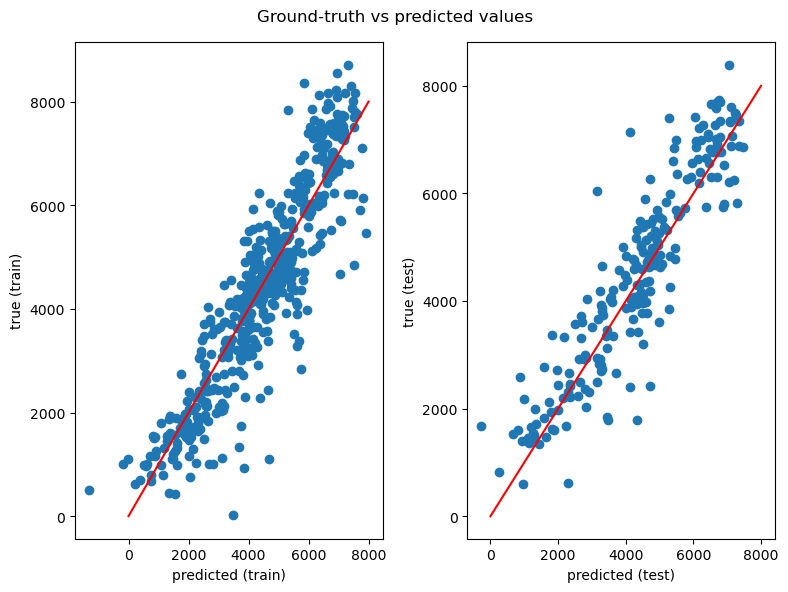

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (8,6))
fig.suptitle('Ground-truth vs predicted values')

# We create a scatter plot of the ground-truth vs predicted values
# Then we plot a linear line (y = x)
# We want the scatter plot points to be close to the linear line

ax[0].scatter(y_pred_train, y_train)
ax[0].set_xlabel('predicted (train)')
ax[0].set_ylabel('true (train)')
ax[0].plot(list(range(8000)), list(range(8000)), color = 'r')

ax[1].scatter(y_pred_test, y_test)
ax[1].set_xlabel('predicted (test)')
ax[1].set_ylabel('true (test)')
ax[1].plot(list(range(8000)), list(range(8000)), color = 'r')

plt.tight_layout()
plt.show()

- Good. The predicted values are relatively close to the y = x line
- Also, the predicted values are randomly distributed on either side of the straight line. 

<h4> 3.3) Inspect the coefficients of the features </h4> 

In [50]:
# Coefficients
dict(zip(basic_model.feature_names_in_, basic_model.coef_))

{'app_temp': 1020.5993236693938,
 'humidity': -290.771194331691,
 'wind_speed': -264.561131688831,
 'year_2012': 1969.381779738156,
 'month_10': 1630.5999664096687,
 'month_11': 973.0515698195386,
 'month_12': 602.0129912033946,
 'month_3': 570.304601419262,
 'month_4': 906.4718662417055,
 'month_5': 1135.1341550021323,
 'month_6': 627.2709719766666,
 'month_7': 92.18819633520592,
 'month_8': 605.1649568549203,
 'month_9': 1570.9944822454063,
 'holiday_yes': -1074.9510718173092,
 'day_of_week_sun': -343.4210493023278,
 'weather_sit_clear': 1799.1249343034983,
 'weather_sit_misty': 1382.4617854229418}

- humidity is negative predictor
- app_temp is positive predictor (because temp goes from around -10 to 35, so within this range, riders will prefer warmer temps)
- winter months are positive predictors, summer months are negative predictors. This seems questionable. 
- holiday day is negative predictor. This makes sense, since majority of riders are registered, who tend to ride to commute (on work days). 
- sunday is negative predictor, which makes sense for reason above
- saturday is positive predictor, which is mysterious, for reason above
- clear and misty weather are positive predictors – makes sense, since alternative is 'bit wet'

<h3> 4) Model with alternate feature selection </h3>

- Before we move on to parameter tuning, I want to return to the selected features again. 
- By eliminating features based on the VIF scores and p values, we ended up with 18 features. This still seems a lot. 
- I'd like to try using common sense and domain knowledge. 
- We saw during the EDA that work_day was a strong predictor. So we will keep that, rather than individual days of the week. 
- Also, I'll use seasons instead of months, which will reduce the number of features while preserving the relevant information. 
- I'll also keep the weather situations for now. 

<h4> 4.1) Select features using common sense and domain knowledge </h4>

In [52]:
features_list = ['year_2012', 'wind_speed', 'temp', 'humidity', 'season_spring', 'season_summer', 'season_winter', 'work_day_yes', 'weather_sit_clear', 'weather_sit_misty']

<h4> 4.2) Check VIF scores </h4>

In [53]:
compute_vif(features_list)

,variable,vif
0,year_2012,1.036951
1,wind_speed,1.187543
2,temp,3.725095
3,humidity,2.039152
4,season_spring,1.588960
5,season_summer,2.750614
6,season_winter,2.279508
7,work_day_yes,1.009997
8,weather_sit_clear,10.821868
9,weather_sit_misty,9.155738


- The VIF scores for the weather situation features are somewhat high, but I think it's more important to preserve this information.
- Especially since we still only have 10 features, which is small enough.

<h4> 4.3) Check p-values </h4>

In [54]:
X_opt = X_enc.copy(deep = True)
X_opt = X_opt[features_list]

scaler = StandardScaler()
scaler.fit(X_opt[['wind_speed', 'temp', 'humidity']])
X_opt[['wind_speed', 'temp', 'humidity']] = scaler.transform(X_opt[['wind_speed', 'temp', 'humidity']])

regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              1928.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        12:10:51   Log-Likelihood:                         -6034.4
No. Observations:                 731   AIC:                                  1.209e+04
Df Residuals:                     721   BIC:                                  1.213e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
year_2012          2102.8215     69.815     30.120      0.000    1965.756    2239.887
wind_speed         -196.5441     37.039     -5.306      0.000    -269.262    -123.827
temp                928.8479     65.847     14.106      0.000     799.573    1058.123
humidity              8.6592     44.987      0.192      0.847     -79.663      96.981
season_spring      -384.7041     99.405     -3.870      0.000    -579.861    -189.547
season_summer      -662.8746    129.007     -5.138      0.000    -916.148    -409.601
season_winter     -1136.1689    120.959     -9.393      0.000   -1373.643    -898.695
work_day_yes        372.9720     72.464      5.147      0.000     230.707     515.237
weather_sit_clear  4026.1171     94.651     42.536      0.000    3840.292    4211.942
weather_sit_misty  3378.7752    109.045     30.985      0.000    3164.691    3592.859
==============================================================================
Omnibus:                       18.949   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.961
Skew:                          -0.085   Prob(JB):                     5.71e-09
Kurtosis:                       4.104   Cond. No.                         6.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value for "humidity" is rather high. But we know that this is important information, so we'll keep it. 

<h4> 4.4) Build model </h4>

In [55]:
X_final = X_enc[features_list]
y = y

# split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=45)

# scale data
scaler = StandardScaler()
scaler.fit(X_train[['wind_speed', 'temp', 'humidity']])
X_train[['wind_speed','temp', 'humidity']] = scaler.transform(X_train[['wind_speed','temp', 'humidity']])
X_test[['wind_speed','temp', 'humidity']] = scaler.transform(X_test[['wind_speed','temp', 'humidity']])

# build model
basic_model = Ridge()
basic_model.fit(X_train, y_train)
y_pred_train = basic_model.predict(X_train)
y_pred_test = basic_model.predict(X_test)

MSE_train = mean_squared_error(y_pred_train, y_train)
MSE_test = mean_squared_error(y_pred_test, y_test)

RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

# Print accuracy and R2 score
100*(1 - (RMSE_test / (df_daily['total'].mean()))), r2_score (y_pred_test, y_test)

(80.29833285924833, 0.7100132888260721)

- We achieve 80% accuracy for the test set. 
- This is only 2% lower than the previous feature selection.
- And the current set of features is only half the size and is far more intuitive. 

<h4> 4.5) Plot true vs predicted values for training and test stes </h4>

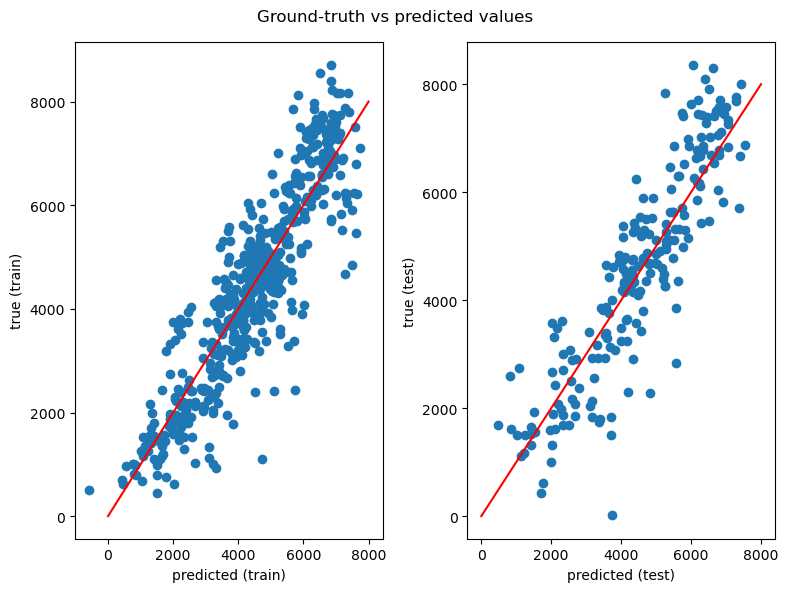

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (8,6))
fig.suptitle('Ground-truth vs predicted values')


ax[0].scatter(y_pred_train, y_train)
ax[0].set_xlabel('predicted (train)')
ax[0].set_ylabel('true (train)')
ax[0].plot(list(range(8000)), list(range(8000)), color = 'r')


ax[1].scatter(y_pred_test, y_test)
ax[1].set_xlabel('predicted (test)')
ax[1].set_ylabel('true (test)')
ax[1].plot(list(range(8000)), list(range(8000)), color = 'r')

plt.tight_layout()
plt.show()

- Good. Once again, the predicted values are relatively close to the y = x line
- Also, the predicted values are randomly distributed on either side of the straight line. 

<h4> 4.6) Check distribution of residuals </h4>

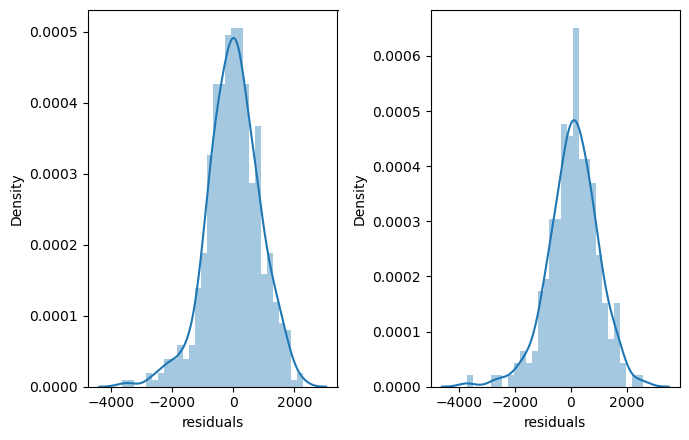

In [62]:
# Create arrays for residuals
res_train = y_train - y_pred_train
res_test = y_test - y_pred_test

# Plot distribution
fig, ax = plt.subplots(1,2,figsize = (7,4.5))
sns.distplot(ax = ax[0], a = res_train, bins = 30)
sns.distplot(ax = ax[1], a = res_test, bins = 30)
ax[0].set(xlabel='residuals')
ax[1].set(xlabel='residuals')
plt.tight_layout()
plt.show()

- Excellent. Distribution of residuals is Gaussian.

<h4> 4.7) Plot regression results against single feature </h4> 

eval_env: 1


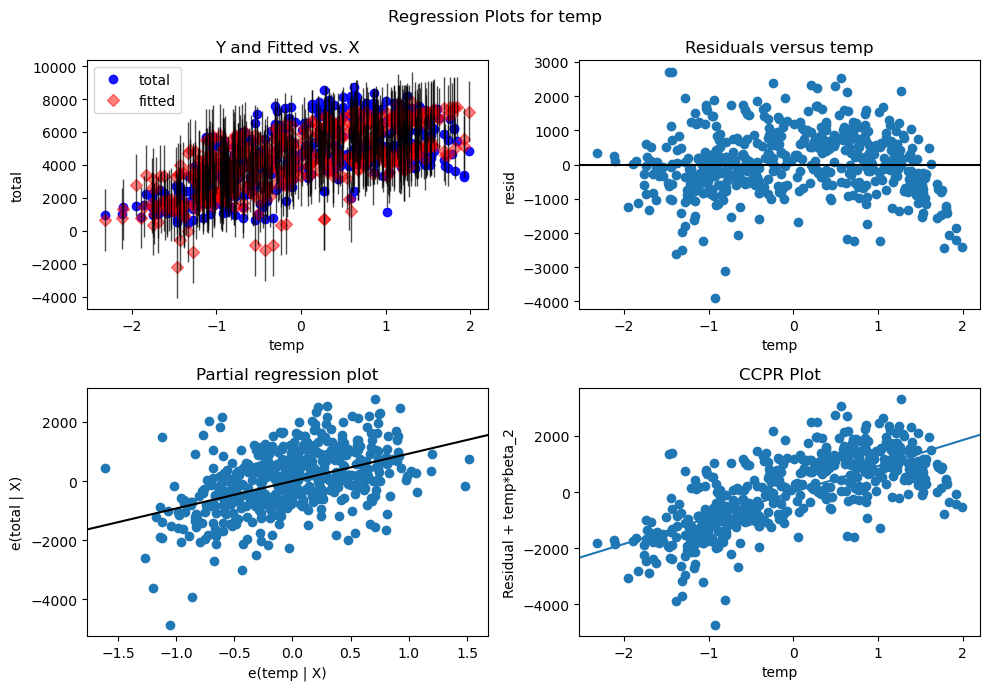

In [67]:
# Plot regresssion against "temp" feature
results = sm.OLS(endog = y_train, exog = X_train).fit()
fig = plt.figure(figsize=(10, 7))
sm.graphics.plot_regress_exog(results, 'temp', fig=fig) #Check as function of "temp" variable
plt.tight_layout()
plt.show()

eval_env: 1


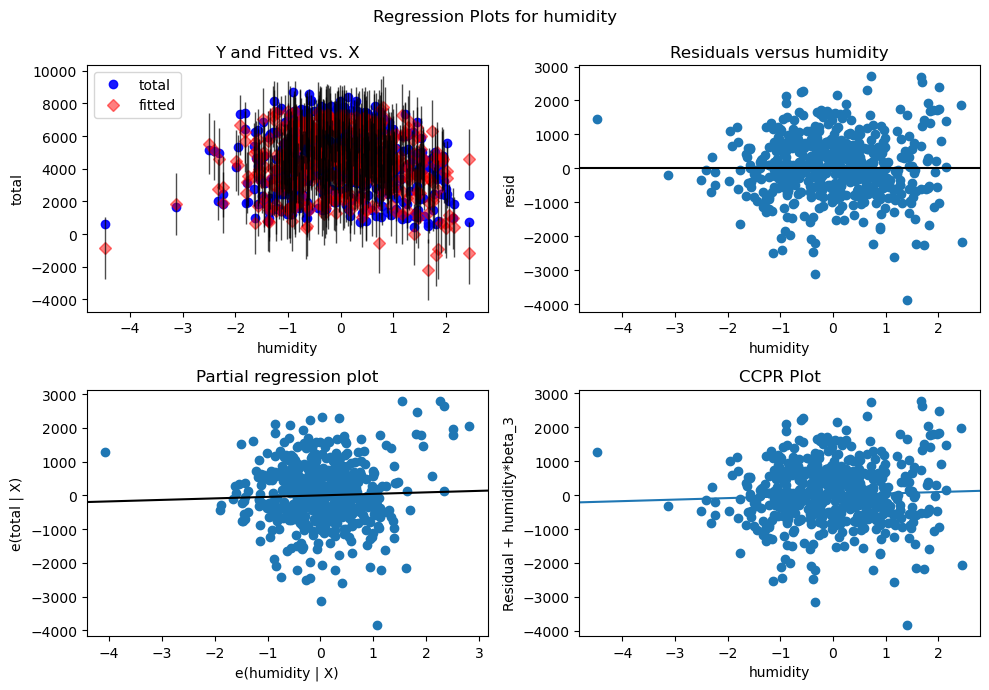

In [68]:
# Plot regression results against "humidity" feature
results = sm.OLS(endog = y_train, exog = X_train).fit()
fig = plt.figure(figsize=(10, 7))
sm.graphics.plot_regress_exog(results, 'humidity', fig=fig) # Check as function of "humidity" variable
plt.show()

<h4> 4.8) Inspect coefficients </h4>

In [69]:
# Coefficients
dict(zip(basic_model.feature_names_in_, basic_model.coef_))

{'year_2012': 1972.6298343075284,
 'wind_speed': -187.23257983820645,
 'temp': 1038.9910849593318,
 'humidity': -148.79711700411866,
 'season_spring': -609.6506696404823,
 'season_summer': -982.8978659970751,
 'season_winter': -1269.6220733513828,
 'work_day_yes': 267.6003712892673,
 'weather_sit_clear': 1800.9559094260567,
 'weather_sit_misty': 1274.8024410321761}

- temperature has big positive correlation, which makes sense. Range of temperature is something like (-10,35), and within that range, higher is def. better
- humidity has negative correlation, which also makes sense. 
- spring and summer have big negative correlation, but this is because "weather_sit_clear" and "weather_sit_misty" have even bigger positive coefficients, and contain information about the season. So the coefficient of the seasons need to be negative to compensate. 
- work day has positive correlation, which makes sense. Majority of riders are registered users, who use bikes to commute.

<h3> General observations so far </h3>

- I tried feature selecting based on VIF and P scores. But even after eliminating redundant features, I still ended up with a huge feature set (20 features). 
- Using this first set of features, I achieved an accuracy of 82% with a base model (with no regularisation)
- I then tried creating an alternate set of features using common sense and domain knowledge.
- This set only includes 10 features – a vast improvement. Moreover, the features are more intuitive and easy to interpret.
- A base model (no regularisation) with this alternate set of features performed with an accuracy of 80%. 
- Given the advantages of having a smaller, more intuitive set of features, I believe the second set of features is the one to go with.

<h3> 5) Parameter tuning </h3>

<h4> 5.1) Training and test error for different regularisation parameters </h4>

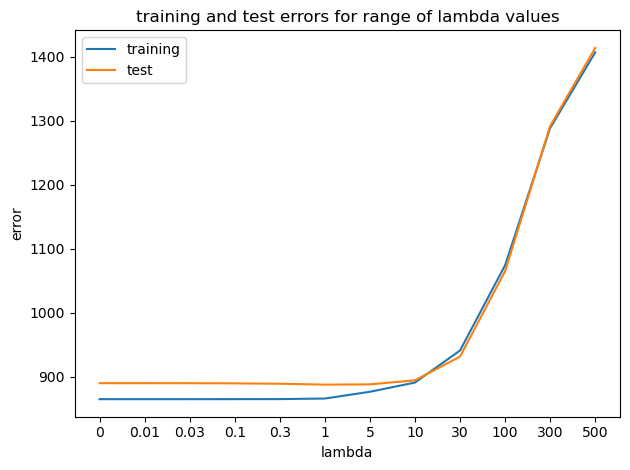

In [77]:
# Plot training error and cv error for a range of lambda values

# Define range of lambda values
from pyexpat.errors import XML_ERROR_EXTERNAL_ENTITY_HANDLING


alphas = [0, 0.01, 0.03, 0.1, 0.3, 1, 5, 10, 30, 100, 300, 500]

# initialise lists for errors and r2 scores
training_errors = []
test_errors = []
r2_scores = []

for alpha in alphas:
    ridge_model = Ridge(alpha = alpha)                      # create linear reg. model, specifying lambda

    ridge_model.fit(X_train, y_train)                # train lin. reg. model to get theta parameters

    y_pred_train = ridge_model.predict(X_train)      # use model to predict for training set
    y_pred_test = ridge_model.predict(X_test)        # use model to predict for test set

    MSE_train = mean_squared_error (y_pred_train, y_train)
    RMSE_train = np.sqrt(MSE_train)

    MSE_test = mean_squared_error (y_pred_test, y_test)
    RMSE_test = np.sqrt(MSE_test)

    training_errors.append(RMSE_train)
    test_errors.append(RMSE_test)

    r2_scores.append(r2_score(y_test, y_pred_test))
    r2_scores.append(r2_score(y_train, y_pred_train))

plt.plot(training_errors, label = 'training')
plt.plot(test_errors, label = 'test')
plt.title('training and test errors for range of lambda values')
plt.xlabel('lambda')
plt.ylabel('error')
plt.xticks(ticks = range(len(alphas)), labels = alphas)
plt.legend()
plt.tight_layout()
plt.show()

<h4> 5.2) Observations on regularisastion </h4>

- Even with no regularisation, we see no over-fitting. 
- If we had over-fitting (high variance), we would see low training error and high test error in the low regularisation region.
- The test error remains lowest (and stable) in the region where lambda is in range (0,10)
- In other words, adding regularisation does not improve our model